# **Importing Data & Dependencies**

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tabulate import tabulate

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import mean_absolute_error, mean_squared_error

from keras.models import Model
from keras.layers import Input, Dense, Embedding, Flatten, Concatenate
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from keras.regularizers import l2

import joblib
import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

users_df = pd.read_csv("/content/drive/My Drive/Users.csv")
ratings_df = pd.read_csv("/content/drive/My Drive/Ratings.csv")
books_df = pd.read_csv("/content/drive/My Drive/Books.csv")

Mounted at /content/drive


In [ ]:
users_df.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [ ]:
ratings_df.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [ ]:
books_df.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


# **Preprocessing Data**

In [3]:
# Merge datasets
merged_df = pd.merge(ratings_df, books_df, on='ISBN')
final_df = pd.merge(merged_df, users_df, on='User-ID')

# Select the features that we need
df_selected = final_df[["User-ID", "Book-Rating", "Book-Title", "Book-Author"]]

# Drop NA values
df_selected = df_selected[df_selected['Book-Rating'] != 0]

# Convert specific columns to integers and strings
df_selected['User-ID'] = df_selected['User-ID'].astype(int)
df_selected['Book-Rating'] = df_selected['Book-Rating'].astype(int)
df_selected['Book-Title'] = df_selected['Book-Title'].astype(str)
df_selected['Book-Author'] = df_selected['Book-Author'].astype(str)

# Define which columns are categorical and numerical
categorical_cols = ['Book-Title', 'Book-Author']
numerical_cols = ['User-ID']

# Preprocessor for categorical and numerical data
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
        ('num', StandardScaler(), numerical_cols)
    ],
    remainder='passthrough'
)

df_selected.shape

(383842, 4)

In [ ]:
df_selected.head()

,User-ID,Book-Rating,Book-Title,Book-Author
1,2313,5,Flesh Tones: A Novel,M. J. Rose
2,2313,9,Ender's Game (Ender Wiggins Saga (Paperback)),Orson Scott Card
3,2313,8,In Cold Blood (Vintage International),TRUMAN CAPOTE
4,2313,9,Divine Secrets of the Ya-Ya Sisterhood : A Novel,Rebecca Wells
5,2313,5,The Mistress of Spices,Chitra Banerjee Divakaruni


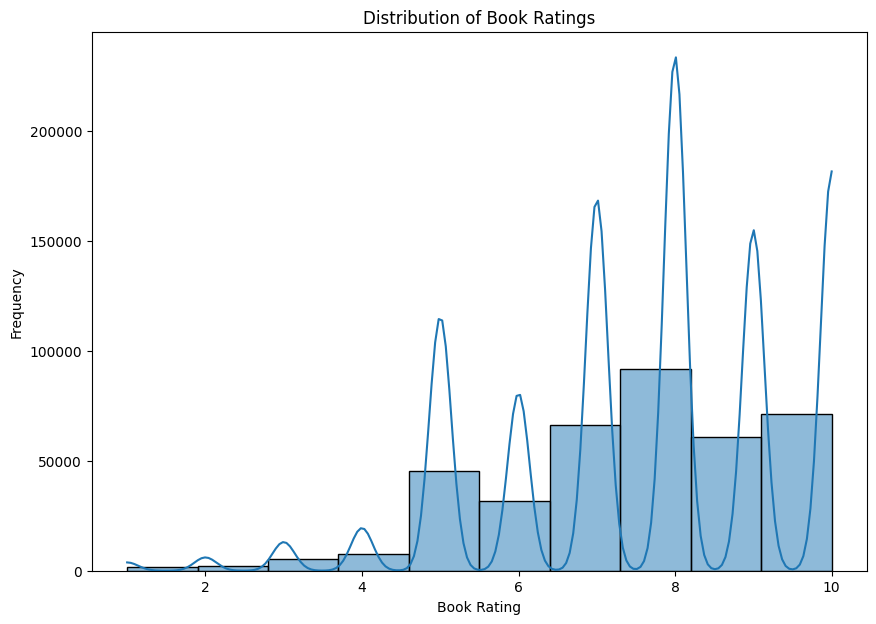

In [ ]:
plt.figure(figsize=(10, 7))
sns.histplot(df_selected['Book-Rating'], bins=10, kde=True)
plt.title('Distribution of Book Ratings')
plt.xlabel('Book Rating')
plt.ylabel('Frequency')
plt.show()

# **The Tensorflow Model**

This model is predicting Book-Rating

In [ ]:
# Split data into train and test sets
X = df_selected.drop(['Book-Rating'], axis=1)
y = df_selected['Book-Rating']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit and transform preprocessing on training data, and transform on test data
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# Save the fitted preprocessor
joblib.dump(preprocessor, 'preprocessor.pkl')

# Apply VarianceThreshold to reduce dimensionality
selector = VarianceThreshold(threshold=0.1)
X_train_selected = selector.fit_transform(X_train_preprocessed)
X_test_selected = selector.transform(X_test_preprocessed)

# Convert sparse matrix to dense array
X_train_selected = X_train_selected.toarray()
X_test_selected = X_test_selected.toarray()

# Mapping user and book IDs
user_id_mapping = {id: idx for idx, id in enumerate(df_selected['User-ID'].unique())}
book_id_mapping = {title: idx for idx, title in enumerate(df_selected['Book-Title'].unique())}

df_selected['user_idx'] = df_selected['User-ID'].map(user_id_mapping)
df_selected['book_idx'] = df_selected['Book-Title'].map(book_id_mapping)

# Split mapped data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df_selected[['user_idx', 'book_idx']], df_selected['Book-Rating'], test_size=0.2, random_state=42)

# Collaborative filtering components
num_users = df_selected['user_idx'].nunique()
num_books = df_selected['book_idx'].nunique()

user_input = Input(shape=(1,), name='user_input')
user_embedding = Embedding(input_dim=num_users, output_dim=32, name='user_embedding')(user_input)
user_vec = Flatten(name='user_flatten')(user_embedding)

book_input = Input(shape=(1,), name='book_input')
book_embedding = Embedding(input_dim=num_books, output_dim=32, name='book_embedding')(book_input)
book_vec = Flatten(name='book_flatten')(book_embedding)

# Additional features component
additional_features_input = Input(shape=(X_train_selected.shape[1],), name='additional_features_input')

# Concatenate collaborative and additional features inputs
concat = Concatenate()([user_vec, book_vec, additional_features_input])
dense1 = Dense(64, activation='relu')(concat)
dense2 = Dense(32, activation='relu')(dense1)
output = Dense(1, activation='linear')(dense2)

# Define and compile the model
model = Model(inputs=[user_input, book_input, additional_features_input], outputs=output)
model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.01), metrics=['mean_squared_error'])

# Implement early stopping to prevent overfitting
early_stopping = EarlyStopping(patience=3, restore_best_weights=True)

# Prepare inputs for training
user_ids_train = X_train['user_idx'].values
book_ids_train = X_train['book_idx'].values
user_ids_test = X_test['user_idx'].values
book_ids_test = X_test['book_idx'].values

# Fit the model with manual validation split
history = model.fit(
    [user_ids_train, book_ids_train, X_train_selected], y_train,
    validation_data=([user_ids_test, book_ids_test, X_test_selected], y_test),
    epochs=20,
    batch_size=64,
    callbacks=[early_stopping]
)

# Evaluate the model
loss, mse = model.evaluate([user_ids_test, book_ids_test, X_test_selected], y_test)
print("Mean Squared Error:", mse)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch 1/20
 101/4799 [..............................] - ETA: 6:15 - loss: 9.7748 - mean_squared_error: 9.7748

# **Evaluating The Model & Personalized Recommendation**


In [58]:
# Calculate average rating across all books
average_rating = df_selected['Book-Rating'].mean()
df = df_selected.copy()
df['AverageRating'] = average_rating

# Calculate MAE and MSE between original ratings and average ratings
mae_baseline = mean_absolute_error(df['Book-Rating'], df['AverageRating'])
mse_baseline = mean_squared_error(df['Book-Rating'], df['AverageRating'])

print(f"Baseline Mean Absolute Error (MAE): {mae_baseline}")
print(f"Baseline Mean Squared Error (MSE): {mse_baseline}")

# Training the model
model.fit([user_ids_train, book_ids_train, X_train_selected], y_train)

# Generate predictions on the test set
predictions = model.predict([user_ids_test, book_ids_test, X_test_selected])
predicted_ratings = predictions.flatten()

# Evaluate the model
mae_model = mean_absolute_error(y_test, predicted_ratings)
mse_model = mean_squared_error(y_test, predicted_ratings)

print(f"Model Mean Absolute Error (MAE): {mae_model}")
print(f"Model Mean Squared Error (MSE): {mse_model}")

Baseline Mean Absolute Error (MAE): 1.4942347405482383
Baseline Mean Squared Error (MSE): 3.3905218063767264
2400/2400 [==============================] - 4s 2ms/step
Model Mean Absolute Error (MAE): 1.2989636281927088
Model Mean Squared Error (MSE): 2.7980434616812513


In [59]:
# Display recommendations
recommendations = pd.DataFrame({
    'User-ID': user_ids_sample,
    'Book-ID': book_ids_sample,
    'Actual Rating': actual_ratings_sample,
    'Predicted Rating': predicted_ratings_sample
})

# Print sample personalized recommendations
print("\nSample Personalized Recommendations:")
print(tabulate(recommendations, headers='keys', tablefmt='psql'))


Sample Personalized Recommendations:
+--------+-----------+-----------+-----------------+--------------------+
|        |   User-ID |   Book-ID |   Actual Rating |   Predicted Rating |
|--------+-----------+-----------+-----------------+--------------------|
| 616913 |      5455 |     17606 |               9 |            7.87478 |
| 769754 |     11678 |     91897 |               6 |            7.86451 |
| 567354 |      4316 |      8185 |               9 |            8.84767 |
| 670494 |      7099 |     25570 |              10 |            8.62565 |
| 373300 |      1528 |     49381 |               9 |            8.46875 |
+--------+-----------+-----------+-----------------+--------------------+


# **Saving the Model**

In [29]:
# Save the model
model.save('tf_model.h5')